In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup

In [23]:
#從檔案讀取電子業股票代號並從中隨機選100檔
df = pd.read_excel('C:\\Users\\user\\Desktop\\MPTIS\\HW1\\現投_股票_台灣電子工業.xlsx')
stocks = df['證券代碼'].unique().tolist()
stocks = [str(i).split(' ')[0] for i in stocks]
stocks = random.sample(stocks, 100)

In [25]:
#用股票代號去爬證交所的股價並存入DataFrame

start_date = '2022-09-15'
end_date = '2023-09-15'
#生成月份區間
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
yyyymm = date_range.strftime('%Y%m').tolist()

stocks_prices = {}
for stock in stocks:
    df = pd.DataFrame(columns=['Date', 'Closing Price'])
    dates = []
    closing_price = []
    for date in yyyymm:
        url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock}'
        response = requests.get(url)
        data = response.json()
        if 'data' in data:
            stock_data = data['data']
            for idx, row in enumerate(stock_data):
                dates.append(row[0])
                if row[6] == '--':
                    closing_price.append(stock_data[idx-1][6])
                else:
                    closing_price.append(row[6])
        else:
            print(f'{stock} 之 {date} 價格爬取失敗')
    df['Date'] = dates
    df['Closing Price'] = closing_price
    stocks_prices[stock] = df

2385 之 202209 價格爬取失敗


In [26]:
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [27]:
stocks_returns = get_stocks_returns(stocks_prices)
len(stocks_returns)

100

In [28]:
# #隨機生成波動率介於0.02~0.15的100組（股票）的收益率
# def random_returns():
#     days = 252
#     samples = 100
#     volatility = np.linspace(0.02, 0.15, 20)    # 每日收益率的標準差（波動率）

#     random_returns = []
#     for i in range(samples):
#         stock_return = np.random.normal(0, random.choice(volatility), days)
#         random_returns.append(stock_return)

#     return np.array(random_returns)

In [29]:
from collections import Counter

#將收益率陣列長度不等於最長天數的股票刪除
def returns_length_reshape(stocks_returns):
    length = []
    for stock in stocks_returns:
        length.append(len(stocks_returns[stock]))
    max_length = Counter(length).most_common(1)[0][0]
    to_del = []
    for stock in stocks_returns:
        if len(stocks_returns[stock]) != max_length:
            #print(f'{stock} 的收益率陣列長度只有 {len(stocks_returns[stock])} 天，不等於最長天數 {max_length}')
            to_del.append(stock)

    #刪除收益率陣列長度不等於最長天數的股票
    for stock in to_del:
        del stocks_returns[stock]

def standard_deviation_matrix(stocks_returns):
    returns = dict(stocks_returns)
    stocks_std = []
    for stock in returns:
        stocks_std.append(np.std(returns[stock]))
    return np.diag(stocks_std)

def correlation_matrix(stocks_returns):
    temp_dict = dict(stocks_returns)     

    #計算相關係數矩陣
    size = len(temp_dict)
    correlation_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i+1, size):
            correlation = np.corrcoef(temp_dict[list(temp_dict.keys())[i]], temp_dict[list(temp_dict.keys())[j]])[0][1]
            correlation_matrix[i][j] = correlation
            correlation_matrix[j][i] = correlation
    np.fill_diagonal(correlation_matrix, 1)
    return correlation_matrix

def V_matrix(stocks_returns):
    V = np.dot(np.dot(standard_deviation_matrix(stocks_returns), correlation_matrix(stocks_returns)), standard_deviation_matrix(stocks_returns))
    return V

In [30]:
returns_length_reshape(stocks_returns)
len(stocks_returns)

99

In [31]:
# #隨機生成V
# def random_V(size):
#     matrix_size = size
#     symmetric_matrix = np.zeros((matrix_size, matrix_size))

#     for i in range(matrix_size):
#         for j in range(i + 1, matrix_size):
#             value = np.random.uniform(-1, 1)
#             symmetric_matrix[i, j] = value
#             symmetric_matrix[j, i] = -value  

#     np.fill_diagonal(symmetric_matrix, 1)

#     return symmetric_matrix

In [32]:
# #隨機生成f
# def random_f(size):
#     f = np.random.rand(size)
#     return f

In [33]:
def get_variance_of_protfolio(V, N):
    avg_of_stocks_variance = np.sum(np.diag(V)) / N
    avg_of_stocks_covariance = np.sum([V[i, j] for i in range(min(V.shape)) for j in range(min(V.shape)) if i != j]) / (N * (N - 1) / 2)
    
    variance_of_protfolio = 1 / N * avg_of_stocks_variance + (N - 1) / N * avg_of_stocks_covariance
    sd = np.sqrt(variance_of_protfolio)

    return variance_of_protfolio

In [34]:
def get_random_stocks(stocks_returns, n):
    temp_dict = dict(stocks_returns)
    
    if n >= len(temp_dict):
        return temp_dict
    else:
        keys = list(temp_dict.keys())
        random_keys = random.sample(keys, n)
        random_elements = {k: temp_dict[k] for k in random_keys}
        return random_elements

In [35]:
sds = []
components = []
repeat = 50

length = len(stocks_returns)

for i in range(2, length):
    sd = 0
    for j in range(repeat):
        random_stocks = get_random_stocks(stocks_returns, i)
        v = V_matrix(random_stocks)
        sd += get_variance_of_protfolio(v, i)
    avg_sd = sd / repeat
    sds.append(avg_sd)
    components.append(i)

C:\Users\user\AppData\Local\Temp\ipykernel_25620\1983199731.py:6: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(variance_of_protfolio)


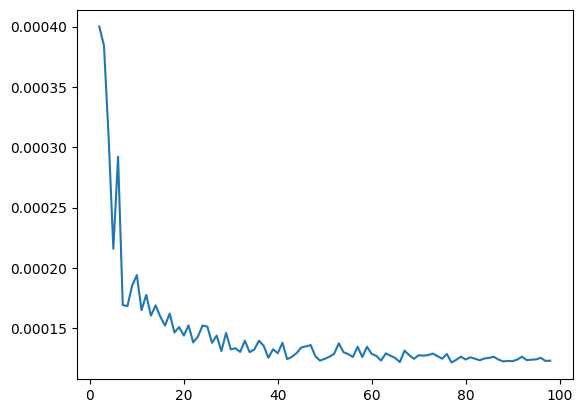

In [36]:
plt.plot(components, sds)